# Introduction

This report presents the modeling of heat transfer in a copper beam using the finite difference method and boundary conditions applied at 10 C° from the left end and 50 C° from the right end. Heat transfer is a fundamental phenomenon encountered in various engineering applications, and understanding the temperature distribution in solid structures is crucial for designing efficient thermal systems.

The heat equation is a partial differential equation that describes how temperature changes over time in a given domain. In one dimension, the heat equation can be expressed as:

$$
    \kappa \frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}}
$$

where u(x, t) represents the temperature distribution along the beam at position x and time t, and α is the thermal diffusivity of the material.

In [1]:
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools

# 1.Create the source function

In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the heat equation, this force is actually a heat peak of magnitude A, width σ and located at position X0 on the beam. In this example, the heat peak is located 60 cm along the beam, with a narrow width.

In [2]:
function source_function(x)
    X0 = 60.0
    σ = 0.8
    A = 1.
    return  A .* exp.(.-((x .- X0).^2)./σ^2)
    #return 0. .* x
end

source_function (generic function with 1 method)

In [3]:
function source(N)
#Parameter
    l = 80.
    dx = l/N
#Mesh
    X_vect = Vector(0:dx:l)
# Function source
    f = source_function(X_vect)
    return f
end

source (generic function with 1 method)

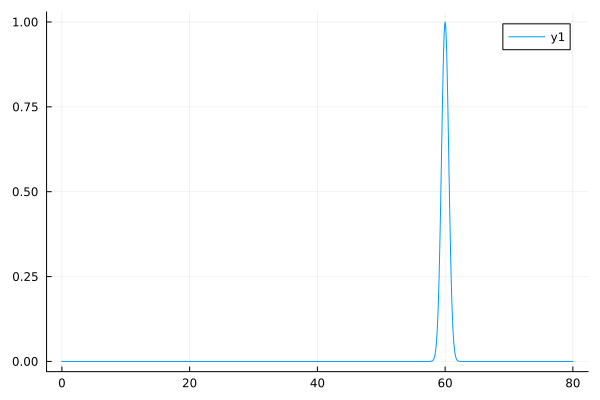

In [4]:
N = 1000
l = 80.
dx = l/N
plot(Vector(0:dx:l),source(N))

# 2.Create the inital function 

In [21]:
function set_initial_condition(x)
    A = 100.
    l = 80
    return A .* sin.((pi / l ) .* x)
end

set_initial_condition (generic function with 1 method)

In [22]:
function init(N)
    #Parameter
        l = 80.
        dx = l/N
    #Mesh
        X_vect = Vector(0:dx:l)
    # Function source
        f = set_initial_condition(X_vect)
        return f
    end

init (generic function with 1 method)

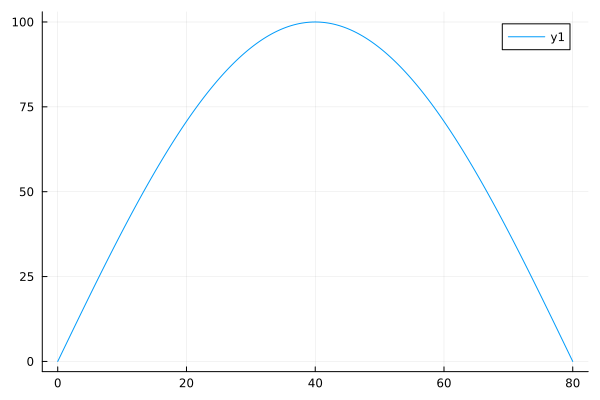

In [23]:
plot(Vector(0:dx:l),init(N))

# 3.Create the Implicit scheme to solve the Heat equation 

The 1D time dependent heat equation is a mathematical model used to describe the distribution of heat in a one-dimensional medium over time.
$$\frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}} $$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
     dt \times f^{N+1}_i+ \frac{\kappa \times dt \times (U_{i+1}^{N+1} -2U_{i}^{N+1} + U_{i-1}^{N+1})}{dx^2} = U^{N+1}_i - U^N_i
$$
With the boudarys conditions :

$$
    U_0 = 150
$$
$$
    U_{N+1} = 0
$$
This leads to a system of linear equations $$ AU^{N+1} = U^N + dt F^{N+1} $$, where A is a tridiagonal matrix that represents the coefficients of the finite difference scheme, x is the vector containing the unknown temperature values at each discretized point. 
$$
A =  \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
-\alpha & 1 + 2 \alpha & -\alpha & \dots & 0 \\
0 & -\alpha & 1 + 2 \alpha & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0  & \ddots & \ddots& - \alpha & 1 + 2 \alpha \\
0  & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

With : $$\alpha = \frac{\kappa \times dt}{dx^2} $$

The vector U^N is is containing the known boundary conditionsso for this example the vector will be : 
$$
    \mathbf{U^N} = \begin{bmatrix} 150 \\ U_2 \\ U_3 \\ \vdots \\ U_N \\ U_{N+1}\end{bmatrix}^N
$$

The heat source must be added to the linear system to get the real case. 

$$
    \mathbf{S} = dt \times \begin{bmatrix} f(0) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(L)\end{bmatrix}^{N+1}
$$



# A) Without source 

In [8]:
function matrix(n) 

#Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ n 
    dt = 1
    α = dt * c^2 /dx^2 

#Build the matrix 
    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 
    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
end

matrix (generic function with 1 method)

In [9]:
function heat_implicit(N) 
    
#Parameters 
    l = 80.
    dx = l/N
    tmax = 1000
    dt = 1
    time_iteration = Int(tmax/dt)
    
#Boudarys and initialization
    U = zeros(N+1, time_iteration + 1)
    U[:,1] .= init(N)
    U[1,:] .= 150
    U[end,:] .= 0
    A = matrix(N)
    
#Solving the linear problem
    for t in 1:time_iteration
        U[:,t+1] = A \ U[:,t] 
    end    

    return U

    
end

heat_implicit (generic function with 1 method)

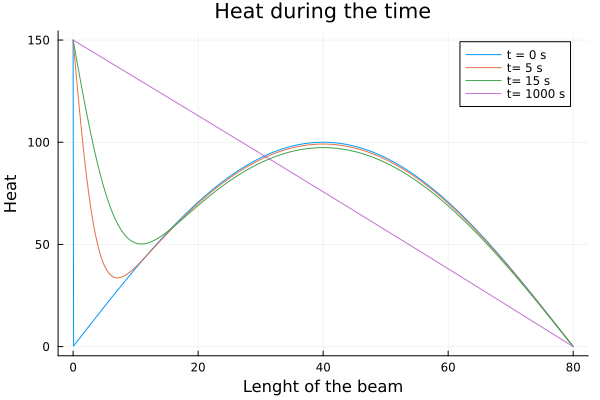

In [10]:
    title = "Heat during the time"
    X = Vector(0:dx:l)
    U = heat_implicit(N)
    plot(X, U[:,1], label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, U[:,6], label = "t= 5 s")
    plot!(X, U[:,16], label = "t= 15 s")
    plot!(X, U[:,end], label = "t= 1000 s")
        

In [11]:
@btime heat_implicit(N)

  625.523 ms (83894 allocations: 1.02 GiB)


1001×1001 Matrix{Float64}:
 150.0       150.0       150.0       …  150.0       150.0       150.0
   0.314159  139.567     144.74         149.852     149.852     149.852
   0.628314  129.905     139.509        149.704     149.704     149.704
   0.942464  120.957     134.331        149.556     149.556     149.556
   1.2566    112.672     129.227        149.409     149.409     149.409
   1.57073   105.004     124.215     …  149.261     149.261     149.261
   1.88484    97.907     119.308        149.113     149.113     149.113
   2.19894    91.3411    114.521        148.965     148.965     148.965
   2.51301    85.2681    109.861        148.817     148.817     148.817
   2.82706    79.6526    105.337        148.669     148.669     148.669
   ⋮                                 ⋱                            ⋮
   2.51301     2.50853     2.50406        1.22108     1.22103     1.22098
   2.19894     2.19502     2.19111        1.06844     1.0684      1.06836
   1.88484     1.88149     1.87813     

# B) With Source 

In [12]:
function heat_implicit_source(N) 
    
#Parameters 
    l = 80.
    dx = l/N
    tmax = 1000
    dt = 1
    time_iteration = Int(tmax/dt)
    
#Boudarys and initialization
    U = zeros(N+1, time_iteration + 1)
    U[:,1] .= init(N)
    U[1,:] .= 150
    U[end,:] .= 0
    S = source(N) 
    A = matrix(N) 

#Solving the linear problem
    for t in 1:time_iteration
        U[:,t+1] = A \ (U[:,t] +  dt *S)
    end    
   return U
    
end 

heat_implicit_source (generic function with 1 method)

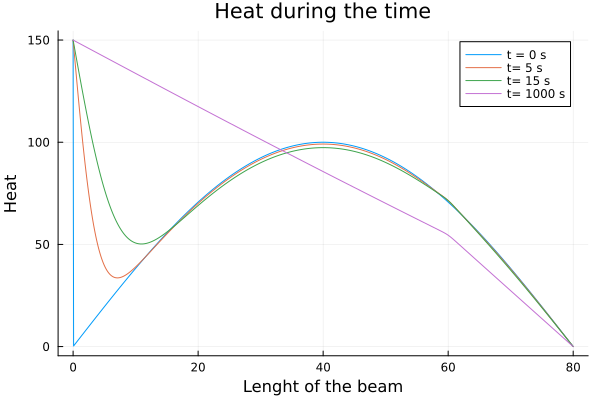

In [13]:
    title = "Heat during the time"
    X = Vector(0:dx:l)
    U = heat_implicit_source(N)
    plot(X, U[:,1], label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, U[:,6], label = "t= 5 s")
    plot!(X, U[:,16], label = "t= 15 s")
    plot!(X, U[:,end], label = "t= 1000 s")

# c) Stability 

The stability analysis of the Implicit Euler method for solving the heat equation using finite differences is crucial in ensuring accurate and reliable numerical solutions. The heat equation represents the diffusion of heat over time in a given domain. The Implicit Euler method is an implicit time-stepping scheme that approximates the solution at the next time step based on the current time step, providing better stability properties compared to explicit methods.

$$
        \alpha U_{i+1}^{N+1} + U^{N}_i  + \alpha U^{N}_{i-1} = (1+2\alpha) U_{i}^{N+1}
$$
$$
        \alpha |U_{i+1}^{N+1}| + |U^{N}_i|  + \alpha |U^{N}_{i-1}| \ge (1+2\alpha) |U_{i}^{N+1}|
$$



With $$ \alpha = \frac{\kappa \times dt}{dx^2} \ge 0$$

So, the Implicit method is always stable because :  $$ 1+2\alpha \ge 0$$
In conclusion, the stability of the Implicit Euler method for the heat equation with finite differences ensures reliable and accurate numerical solutions. Its unconditional stability allows for larger time steps, facilitating faster computations while maintaining stability. By carefully managing the numerical diffusion, the Implicit Euler method can provide an effective and robust approach for solving the heat equation in various practical applications.


# 4.Create the explicit scheme to solve the heat equation 

The 1D time dependent heat equation is a mathematical model used to describe the distribution of heat in a one-dimensional medium over time.
$$\frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}} $$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
     dt \times f^{N}_i+ \frac{\kappa \times dt \times (U_{i+1}^{N} -2U_{i}^{N} + U_{i-1}^{N})}{dx^2} = U^{N+1}_i - U^N_i
$$
With the boudarys conditions :

$$
    U_0 = 150
$$
$$
    U_{N+1} = 0
$$

This time, I will use a iterative method that can be explained by the system : 

$$
        dt f^{N}_i+  \alpha U_{i+1}^{N} + (1-2\alpha) U_{i}^{N} + \alpha U^{N}_{i-1} = U^{N+1}_i 
$$

With $$ \alpha = \frac{\kappa \times dt}{dx^2}$$


# A) Without source 

In [14]:
function heat_explicit(N,tmax) #Iterative method 
    #Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ N  
   # tmax = 60
    dt = 0.001
    α = dt * c^2 /dx^2 
    
    #Init vector  
        u = init(N)
        
    #Boundarys 
        u[1] = 150.
        u[N+1] = 0.0
      
    #Solve the system
        Unp1 = copy(u)
        for j in 1:dt: Int(tmax)
            for i in 2:N
                Unp1[i] = α * (u[i+1] - 2 * u[i] + u[i-1]) + u[i]
            end 
            u = Unp1
        end 
    
        return u
end

heat_explicit (generic function with 1 method)

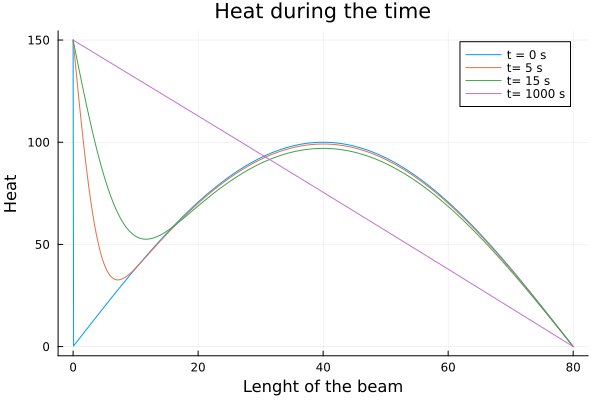

In [15]:
    plot(X, heat_explicit(N,0), label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, heat_explicit(N,5), label = "t= 5 s")
    plot!(X, heat_explicit(N,15), label = "t= 15 s")
    plot!(X, heat_explicit(N,1000), label = "t= 1000 s")

In [16]:
@btime heat_explicit(N,1000)

  4.230 s (3 allocations: 24.00 KiB)


1001-element Vector{Float64}:
 150.0
 149.8515748214048
 149.70314962562563
 149.55472439858693
 149.40629912621333
 149.25787379442968
 149.10944838916132
 148.96102289633382
 148.81259730187347
 148.6641715917071
   ⋮
   1.2133741028761627
   1.0617026404510181
   0.9100310562693289
   0.7583593682887734
   0.606687594468336
   0.45501575276807177
   0.30334386114887196
   0.15167193757222863
   0.0

# B) With source 

In [17]:
function heat_explicit(N,tmax) #Iterative method 
#Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ N  
    dt = 0.001
    α = dt * c^2 /dx^2 
    
#Init vector  
    u = init(N)

#Boundarys 
    u[1] = 150.
    u[N+1] = 0.0
    f = source(N)

#Solve the system
    Unp1 = copy(u)
    for j in 1:dt: Int(tmax)
        for i in 2:N
            Unp1[i] = α * (u[i+1] - 2 * u[i] + u[i-1]) + u[i] + dt * f[i]
        end 
        u = Unp1
    end 

    return u 
end

heat_explicit (generic function with 1 method)

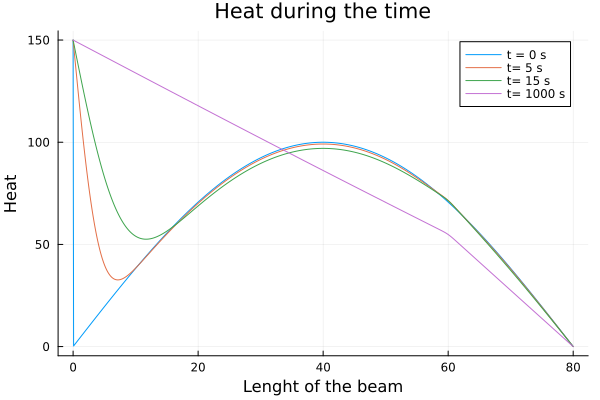

In [18]:
    plot(X, heat_explicit(N,0), label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, heat_explicit(N,5), label = "t= 5 s")
    plot!(X, heat_explicit(N,15), label = "t= 15 s")
    plot!(X, heat_explicit(N,1000), label = "t= 1000 s")

# c) Stability 

The stability analysis of the Explicit Euler method for solving the heat equation with finite differences is an important consideration in numerical simulations. The Explicit Euler method is an explicit time-stepping scheme commonly used for solving partial differential equations.

To analyze the stability of the Explicit Euler method, I will use the scheme : 

$$
    \alpha U_{i+1}^{N} + (1-2\alpha) U_{i}^{N} + \alpha U^{N}_{i-1} = U^{N+1}_i 
$$

$$
    \alpha| U_{i+1}^{N}| + (1-2\alpha) |U_{i}^{N}| + \alpha |U^{N}_{i-1}| \ge |U^{N+1}_i| 
$$

With $$ \alpha = \frac{\kappa \times dt}{dx^2} \ge 0$$

To be stable, there is the condition $$ (1-2\alpha) \ge 0 $$ 

That show the CFL stability condition : 

$$ \frac{1}{2}  \le \alpha $$ 

So :

$$ 


 \frac{dx^2}{2\kappa } \ge dt

$$
In conclusion, the stability of the Explicit Euler method for the heat equation with finite differences depends on the time step size relative to the spatial discretization and thermal diffusivity coefficient. Choosing a small enough time step size is essential to ensure stability and accurate numerical solutions. However, it is important to note that the Explicit Euler method has a restrictive stability condition, which often requires smaller time steps compared to implicit methods for the same accuracy.